In [1]:
from glob import glob
import os as os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from skimage.feature import hog
from skimage import exposure
from skimage import io, feature
from skimage.feature import hog, local_binary_pattern
from tqdm import tqdm
from cv2 import cvtColor
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

Load images from folder


In [2]:
CLASS_NAMES = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

def augImg(img):
    flipped = cv2.flip(img, 1) # horizontal flip
    return flipped
def skew(img):
    rows, cols, ch = img.shape
    pts1 = np.float32([[50,50],[200,50],[50,200]])
    pts2 = np.float32([[10,100],[200,50],[100,250]])
    M = cv2.getAffineTransform(pts1,pts2)
    dst = cv2.warpAffine(img,M,(cols,rows))
    return dst
def load_images_from_folder(folder, augment=True):
    images, labels = [], []
    for label, className in enumerate(CLASS_NAMES):
        class_folder = os.path.join(folder, className)
        for filename in os.listdir(class_folder):
            img = cv2.imread(os.path.join(class_folder, filename))
            if img is None:
                continue
            img = cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (128, 128))
            images.append(img)
            labels.append(label)
            if augment:
                images.append(augImg(img))
                labels.append(label)
                images.append(skew(img))
                labels.append(label)
                cropped = tf.image.central_crop(img, central_fraction=0.5).numpy()
                cropped = cv2.resize(cropped, (128, 128))
                images.append(cropped)
                labels.append(label)
    return np.array(images), np.array(labels)

In [3]:
X_train, y_train = load_images_from_folder('intel-image-classification/seg_train/seg_train/', augment=True)
X_test, y_test = load_images_from_folder('intel-image-classification/seg_test/seg_test/', augment=False)
data_mengde = 20 # bruk kun 1 av X bilder
train_sel = np.arange(0, len(X_train), data_mengde)
test_sel = np.arange(0, len(X_test), data_mengde)
X_train_short = X_train[train_sel]
y_train_short = y_train[train_sel]
X_test_short = X_test[test_sel]
y_test_short = y_test[test_sel]

print("Brukte "+ str(round(100/data_mengde, 2)) +"% av dataen")
print(X_train_short.shape, y_train_short.shape)
print(X_test_short.shape, y_test_short.shape)

Brukte 5.0% av dataen
(2807, 128, 128, 3) (2807,)
(150, 128, 128, 3) (150,)


[RandomForest](#randomforest)\
[XGBoost](#xgboost)\
[SVM](#svm)\
[Stacking](#stacking)\
[Feature selection](#feature_selection)
---
---

# RandomForest

In [4]:
import cv2
import numpy as np
from skimage.feature import hog, local_binary_pattern
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import matplotlib.pyplot as plt
import itertools

# -----------------------------
# Feature extraction function
# -----------------------------
def extract_features(batch, method="hog", hog_params=None, lbp_params=None):
    feats = []
    for img in tqdm(batch, desc=f"Extracting {method} features"):
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        
        if method == "hog":
            fd = hog(
                gray,
                orientations=hog_params.get("orientations", 9),
                pixels_per_cell=hog_params.get("pixels_per_cell", (8,8)),
                cells_per_block=hog_params.get("cells_per_block", (3,3)),
                visualize=False,
                channel_axis=None
            )
            feats.append(fd)
        
        elif method == "lbp":
            lbp = local_binary_pattern(
                gray,
                P=lbp_params.get("P", 8),
                R=lbp_params.get("R", 1),
                method=lbp_params.get("method", "uniform")
            )
            lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, lbp.max() + 2), density=True)
            feats.append(lbp_hist)
        
        elif method == "hog+lbp":
            # Combine HOG + LBP
            fd = hog(
                gray,
                orientations=hog_params.get("orientations", 9),
                pixels_per_cell=hog_params.get("pixels_per_cell", (8,8)),
                cells_per_block=hog_params.get("cells_per_block", (3,3)),
                visualize=False,
                channel_axis=None
            )
            lbp = local_binary_pattern(
                gray,
                P=lbp_params.get("P", 8),
                R=lbp_params.get("R", 1),
                method=lbp_params.get("method", "uniform")
            )
            lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, lbp.max() + 2), density=True)
            feats.append(np.concatenate([fd, lbp_hist]))
        
        else:
            raise ValueError("Unknown feature extraction method")
    
    return np.asarray(feats, dtype=np.float32)

# -----------------------------
# Parameter grid
# -----------------------------
hog_params_list = [
    {"orientations": 9, "pixels_per_cell": (8,8), "cells_per_block": (3,3)},
    {"orientations": 16, "pixels_per_cell": (8,8), "cells_per_block": (2,2)},
]

lbp_params_list = [
    {"P": 8, "R": 1, "method": "uniform"},
    {"P": 10, "R": 3, "method": "uniform"},
]

methods = ["hog", "lbp", "hog+lbp"]

results_rf = []

# Method sweep
for method in methods:
    if method == "hog":
        param_pairs = [(hp, {}) for hp in hog_params_list]
    elif method == "lbp":
        param_pairs = [({}, lp) for lp in lbp_params_list]
    else:  # hog+lbp
        param_pairs = [(hp, lp) for hp in hog_params_list for lp in lbp_params_list]

    for hp_use, lp_use in param_pairs:
        # Extract features
        X_train_feats = extract_features(X_train_short, method=method,
                                         hog_params=hp_use, lbp_params=lp_use)
        X_test_feats = extract_features(X_test_short, method=method,
                                        hog_params=hp_use, lbp_params=lp_use)

        clf = RandomForestClassifier(random_state=42, max_depth=None, n_estimators=300, min_samples_split=5)
        clf.fit(X_train_feats, y_train_short)

        train_acc = accuracy_score(y_train_short, clf.predict(X_train_feats))
        test_acc = accuracy_score(y_test_short, clf.predict(X_test_feats))

        results_rf.append({
            "method": method,
            "hog_params": hp_use,
            "lbp_params": lp_use,
            "test_acc": test_acc
        })
        print(f"Method: {method}, HOG: {hp_use}, LBP: {lp_use} -> Train: {train_acc:.3f}, Test: {test_acc:.3f}")

Extracting hog features: 100%|██████████| 150/150 [00:00<00:00, 250.64it/s]


Method: hog, HOG: {'orientations': 9, 'pixels_per_cell': (8, 8), 'cells_per_block': (3, 3)}, LBP: {} -> Train: 1.000, Test: 0.633


Extracting hog features: 100%|██████████| 150/150 [00:00<00:00, 210.38it/s]


Method: hog, HOG: {'orientations': 16, 'pixels_per_cell': (8, 8), 'cells_per_block': (2, 2)}, LBP: {} -> Train: 1.000, Test: 0.620


Extracting lbp features: 100%|██████████| 150/150 [00:00<00:00, 599.13it/s]


Method: lbp, HOG: {}, LBP: {'P': 8, 'R': 1, 'method': 'uniform'} -> Train: 0.995, Test: 0.540


Extracting lbp features: 100%|██████████| 150/150 [00:00<00:00, 494.60it/s]


Method: lbp, HOG: {}, LBP: {'P': 10, 'R': 3, 'method': 'uniform'} -> Train: 0.996, Test: 0.547


Extracting hog+lbp features: 100%|██████████| 150/150 [00:00<00:00, 175.66it/s]


Method: hog+lbp, HOG: {'orientations': 9, 'pixels_per_cell': (8, 8), 'cells_per_block': (3, 3)}, LBP: {'P': 8, 'R': 1, 'method': 'uniform'} -> Train: 1.000, Test: 0.647


Extracting hog+lbp features: 100%|██████████| 150/150 [00:00<00:00, 154.30it/s]


Method: hog+lbp, HOG: {'orientations': 9, 'pixels_per_cell': (8, 8), 'cells_per_block': (3, 3)}, LBP: {'P': 10, 'R': 3, 'method': 'uniform'} -> Train: 1.000, Test: 0.607


Extracting hog+lbp features: 100%|██████████| 150/150 [00:01<00:00, 149.85it/s]


Method: hog+lbp, HOG: {'orientations': 16, 'pixels_per_cell': (8, 8), 'cells_per_block': (2, 2)}, LBP: {'P': 8, 'R': 1, 'method': 'uniform'} -> Train: 1.000, Test: 0.600


Extracting hog+lbp features: 100%|██████████| 150/150 [00:01<00:00, 140.76it/s]


Method: hog+lbp, HOG: {'orientations': 16, 'pixels_per_cell': (8, 8), 'cells_per_block': (2, 2)}, LBP: {'P': 10, 'R': 3, 'method': 'uniform'} -> Train: 1.000, Test: 0.600


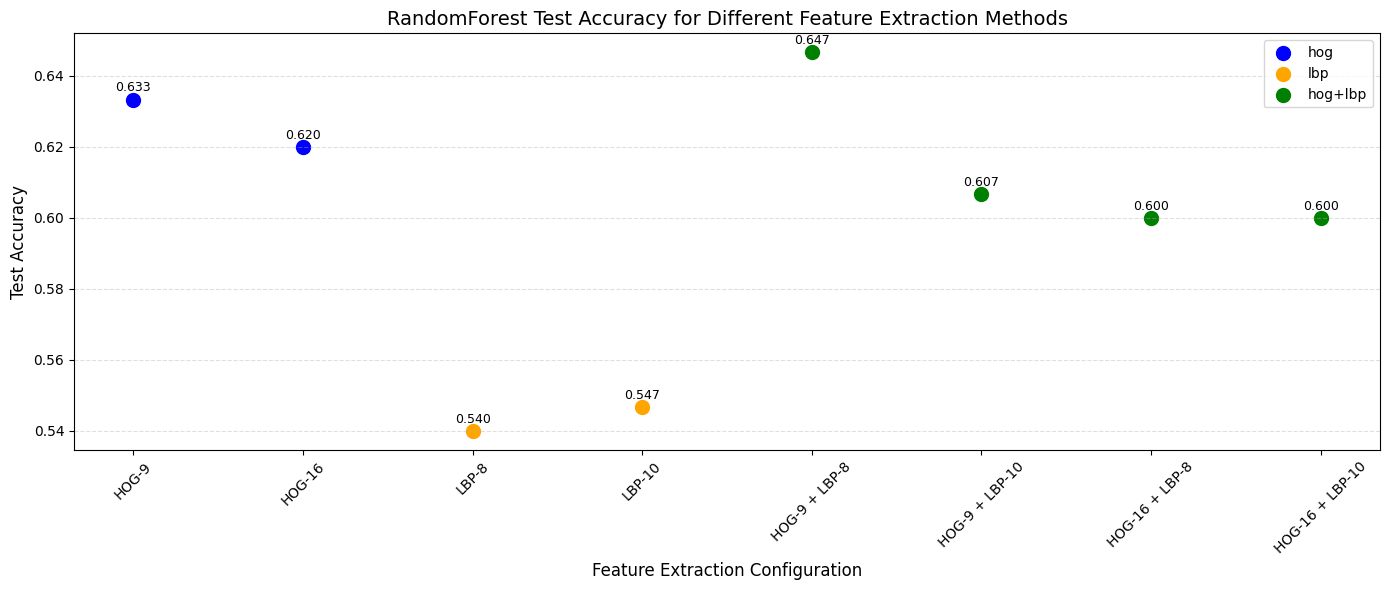

In [5]:
# -----------------------------
# Plot comparison (with point labels and correct colors)
# -----------------------------
df_results_rf = pd.DataFrame(results_rf)

colors = {"hog": "blue", "lbp": "orange", "hog+lbp": "green"}

plt.figure(figsize=(14,6))

added_to_legend = set()  # to avoid duplicate legend labels

for idx, row in df_results_rf.iterrows():
    x = idx
    y = row["test_acc"]
    method = row["method"]

    # Draw the scatter point, with color tied to method
    plt.scatter(
        x, y,
        color=colors[method],
        s=100,
        label=method if method not in added_to_legend else None
    )
    added_to_legend.add(method)

    # Add value label slightly above the point
    plt.text(
        x, y + 0.0015,
        f"{y:.3f}",
        ha="center", va="bottom",
        fontsize=9
    )

def pretty_label(method, hp, lp):
    if method == "hog":
        return f"HOG-{hp['orientations']}"
    elif method == "lbp":
        return f"LBP-{lp['P']}"
    else:  # hog+lbp
        return f"HOG-{hp['orientations']} + LBP-{lp['P']}"

plt.xticks(
    range(len(df_results_rf)),
    [
        pretty_label(r['method'], r['hog_params'], r['lbp_params'])
        for _, r in df_results_rf.iterrows()
    ],
    rotation=45
)

plt.xlabel("Feature Extraction Configuration", fontsize=12)
plt.ylabel("Test Accuracy", fontsize=12)
plt.title("RandomForest Test Accuracy for Different Feature Extraction Methods", fontsize=14)
plt.grid(True, axis="y", linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()


| Label example      | Meaning                              |
| ------------------ | ------------------------------------ |
| **HOG-9**      | HOG with 9 orientations   |
| **HOG-16**     | HOG with 16 orientations  |
| **LBP-8**      | LBP with 8 points              |
| **LBP-10**     | LBP with 10 points             |
| **HOG-9 + LBP-8** | HOG with 16 bins + LBP with 8 points |

The parameter sweep and resulting accuracy plot clearly show that **HOG features consistently outperform LBP features** when used independently with a RandomForest classifier. HOG with either 9 or 16 orientation bins produces test accuracies in the range of **0.62–0.63**, which is notably higher than the LBP configurations, which remain around **0.54–0.55** regardless of whether 8 or 10 sampling points are used. This difference reflects the fact that HOG captures richer gradient-based spatial structure—edges, shapes, and contours—while LBP focuses primarily on local texture micro-patterns. For a dataset where global shape information is more important than fine-grained texture, HOG will generally provide a more informative feature space for tree-based models.

LBP on its own underperforms because RandomForests tend to benefit from moderately high-dimensional, discriminative features that capture variation at different spatial scales, whereas LBP produces relatively coarse binary patterns that emphasize uniform local texture. Even with different P values (8 vs. 10 sampling points), the performance remains tightly clustered around 0.54–0.55, indicating that changing the radius or number of neighbors does not significantly increase discriminative power for this dataset. This suggests that the dataset’s class boundaries are not strongly explained by micro-textures alone, and LBP’s invariance properties may also reduce useful variation that the classifier could exploit.

The combined **HOG+LBP** features perform between the individual methods: better than LBP alone, but not always exceeding HOG alone. Their accuracies cluster around **0.60–0.65**, with the best combination (HOG-9 + LBP-8) reaching the highest overall accuracy of roughly **0.647**. This indicates that LBP contributes some complementary information, but not enough to consistently improve upon HOG alone. RandomForests may also struggle with the increased dimensionality when HOG and LBP are concatenated, especially if some dimensions are redundant or noisy. Overall, the results show that HOG is the most useful individual descriptor, while combining it with LBP can offer moderate improvements but is not uniformly beneficial across parameter settings.


# XGBoost

In [6]:
from xgboost import XGBClassifier

results_xgb = []

# Method sweep using XGBoost instead of RandomForest
for method in methods:
    if method == "hog":
        param_pairs = [(hp, {}) for hp in hog_params_list]
    elif method == "lbp":
        param_pairs = [({}, lp) for lp in lbp_params_list]
    else:  # hog+lbp
        param_pairs = [(hp, lp) for hp in hog_params_list for lp in lbp_params_list]

    for hp_use, lp_use in param_pairs:

        # Extract features
        X_train_feats = extract_features(
            X_train_short, method=method,
            hog_params=hp_use, lbp_params=lp_use
        )
        X_test_feats = extract_features(
            X_test_short, method=method,
            hog_params=hp_use, lbp_params=lp_use
        )

        # --- Ultra-fast XGBoost ---
        xgb_clf = XGBClassifier(
            objective="multi:softmax",
            num_class=len(CLASS_NAMES),

            # Reduce tree complexity
            max_depth=3,            # shallower trees → much faster
            n_estimators=80,        # fewer boosting rounds
            learning_rate=0.15,     # slightly higher to compensate

            # Reduce data per tree
            subsample=0.5,          # only half of training rows per tree
            colsample_bytree=0.4,   # only 40% of features per tree

            # Performance settings
            tree_method="hist",     # fast histogram-based tree growth
            random_state=42,
            eval_metric="mlogloss",
            use_label_encoder=False  # avoids warnings and slightly faster
        )


        xgb_clf.fit(X_train_feats, y_train_short)
        xgb_pred = xgb_clf.predict(X_test_feats)

        test_acc = accuracy_score(y_test_short, xgb_pred)

        results_xgb.append({
            "method": method,
            "hog_params": hp_use,
            "lbp_params": lp_use,
            "test_acc": test_acc
        })

        print(
            f"Method: {method}, "
            f"HOG: {hp_use if hp_use else '-'}, "
            f"LBP: {lp_use if lp_use else '-'} "
            f"-> Test Accuracy: {test_acc:.3f}"
        )


Extracting hog features: 100%|██████████| 150/150 [00:00<00:00, 252.78it/s]
c:\Users\williaht\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [00:16:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Method: hog, HOG: {'orientations': 9, 'pixels_per_cell': (8, 8), 'cells_per_block': (3, 3)}, LBP: - -> Test Accuracy: 0.653


Extracting hog features: 100%|██████████| 150/150 [00:00<00:00, 211.53it/s]
c:\Users\williaht\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [00:19:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Method: hog, HOG: {'orientations': 16, 'pixels_per_cell': (8, 8), 'cells_per_block': (2, 2)}, LBP: - -> Test Accuracy: 0.620


Extracting lbp features: 100%|██████████| 150/150 [00:00<00:00, 602.90it/s]
c:\Users\williaht\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [00:22:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Method: lbp, HOG: -, LBP: {'P': 8, 'R': 1, 'method': 'uniform'} -> Test Accuracy: 0.520


Extracting lbp features: 100%|██████████| 150/150 [00:00<00:00, 481.57it/s]
c:\Users\williaht\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [00:22:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Method: lbp, HOG: -, LBP: {'P': 10, 'R': 3, 'method': 'uniform'} -> Test Accuracy: 0.487


Extracting hog+lbp features: 100%|██████████| 150/150 [00:00<00:00, 174.99it/s]
c:\Users\williaht\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [00:22:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Method: hog+lbp, HOG: {'orientations': 9, 'pixels_per_cell': (8, 8), 'cells_per_block': (3, 3)}, LBP: {'P': 8, 'R': 1, 'method': 'uniform'} -> Test Accuracy: 0.707


Extracting hog+lbp features: 100%|██████████| 150/150 [00:00<00:00, 161.03it/s]
c:\Users\williaht\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [00:26:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Method: hog+lbp, HOG: {'orientations': 9, 'pixels_per_cell': (8, 8), 'cells_per_block': (3, 3)}, LBP: {'P': 10, 'R': 3, 'method': 'uniform'} -> Test Accuracy: 0.713


Extracting hog+lbp features: 100%|██████████| 150/150 [00:01<00:00, 145.90it/s]
c:\Users\williaht\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [00:29:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Method: hog+lbp, HOG: {'orientations': 16, 'pixels_per_cell': (8, 8), 'cells_per_block': (2, 2)}, LBP: {'P': 8, 'R': 1, 'method': 'uniform'} -> Test Accuracy: 0.687


Extracting hog+lbp features: 100%|██████████| 150/150 [00:01<00:00, 145.86it/s]
c:\Users\williaht\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [00:32:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Method: hog+lbp, HOG: {'orientations': 16, 'pixels_per_cell': (8, 8), 'cells_per_block': (2, 2)}, LBP: {'P': 10, 'R': 3, 'method': 'uniform'} -> Test Accuracy: 0.627


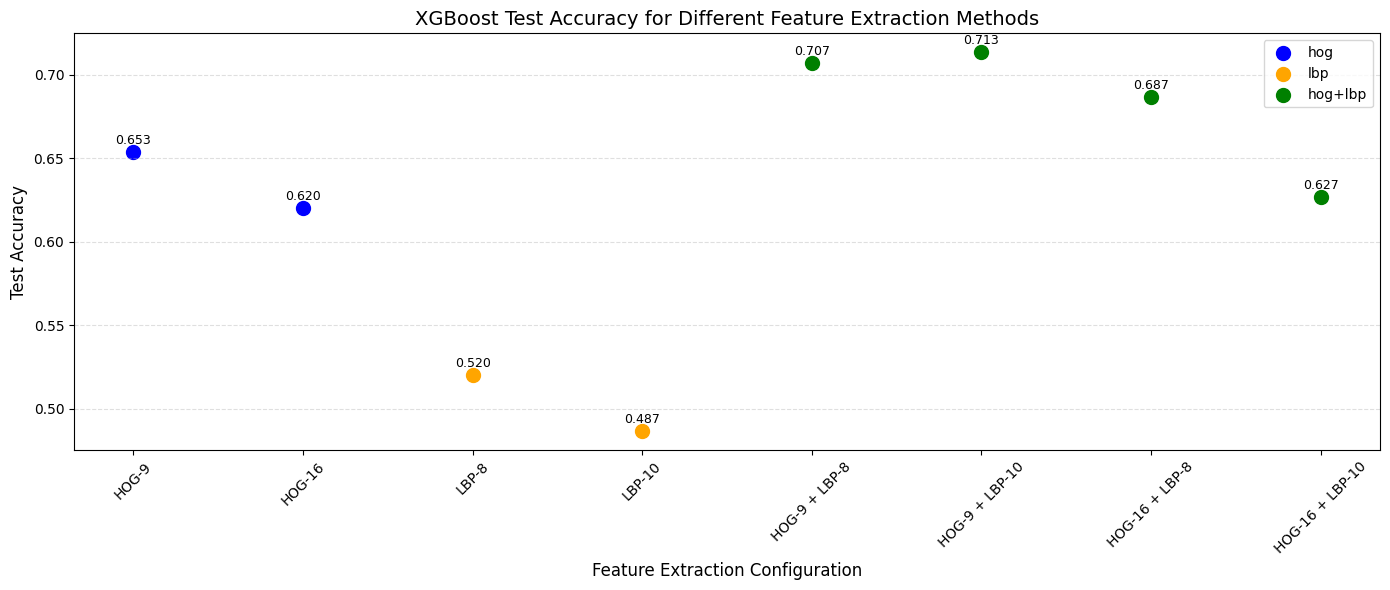

In [7]:
# -----------------------------
# Plot comparison (XGBoost version)
# -----------------------------
df_results_xgb = pd.DataFrame(results_xgb)

colors = {"hog": "blue", "lbp": "orange", "hog+lbp": "green"}

plt.figure(figsize=(14,6))

added_to_legend = set()  # avoid duplicate legend labels

for idx, row in df_results_xgb.iterrows():
    x = idx
    y = row["test_acc"]
    method = row["method"]

    # Draw scatter point with method-specific color
    plt.scatter(
        x, y,
        color=colors[method],
        s=100,
        label=method if method not in added_to_legend else None
    )
    added_to_legend.add(method)

    # Add text above point
    plt.text(
        x, y + 0.003,
        f"{y:.3f}",
        ha="center", va="bottom",
        fontsize=9
    )

# Nicely formatted x-axis labels
def pretty_label(method, hp, lp):
    if method == "hog":
        return f"HOG-{hp['orientations']}"
    elif method == "lbp":
        return f"LBP-{lp['P']}"
    else:  # hog+lbp
        return f"HOG-{hp['orientations']} + LBP-{lp['P']}"

plt.xticks(
    range(len(df_results_xgb)),
    [
        pretty_label(r['method'], r['hog_params'], r['lbp_params'])
        for _, r in df_results_xgb.iterrows()
    ],
    rotation=45
)

plt.xlabel("Feature Extraction Configuration", fontsize=12)
plt.ylabel("Test Accuracy", fontsize=12)
plt.title("XGBoost Test Accuracy for Different Feature Extraction Methods", fontsize=14)
plt.grid(True, axis="y", linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()


| Method    | HOG Orientations | LBP Points (P) | Test Accuracy |
| --------- | ---------------- | -------------- | ------------- |
| HOG       | 9                | -              | 0.653         |
| HOG       | 16               | -              | 0.620         |
| LBP       | -                | 8              | 0.520         |
| LBP       | -                | 10             | 0.487         |
| HOG + LBP | 9                | 8              | 0.707         |
| HOG + LBP | 9                | 10             | 0.713         |
| HOG + LBP | 16               | 8              | 0.687         |
| HOG + LBP | 16               | 10             | 0.627         |


Effect of HOG parameters on accuracy

The HOG-only feature extraction results show that using 9 orientations outperforms 16 orientations slightly (65.3% vs. 62.0%). This suggests that increasing the number of orientations beyond a certain point might add redundant or noisy information, slightly reducing model generalization. The simpler configuration with fewer orientations is enough to capture key shape and edge features relevant for classifying these image classes. Thus, a moderate HOG parameter setting helps maintain good performance without unnecessary complexity.

Effect of LBP parameters on accuracy

The LBP-only features yield lower accuracy overall compared to HOG, with 8 sampling points performing better than 10 points (52.0% vs. 48.7%). Increasing the number of points in LBP may introduce more local texture detail but can also increase noise or variability, which might reduce classifier accuracy. LBP is known to capture fine texture patterns, but for this dataset and XGBoost model, simpler LBP parameters seem more effective than higher complexity.

Combining HOG and LBP features

Combining HOG and LBP features consistently improves accuracy over either method alone. The highest accuracy (71.3%) is achieved with HOG-9 orientations combined with LBP-10 points, demonstrating complementary benefits of capturing both shape and texture information. Interestingly, increasing HOG orientations to 16 while combining with LBP yields slightly lower accuracy, reflecting the previous trend that higher HOG complexity is less helpful. Overall, feature fusion provides richer information for XGBoost to leverage, significantly boosting classification performance across the diverse image classes.

This analysis highlights how tuning feature extraction parameters impacts model accuracy, balancing complexity and representational richness for optimal image classification.

# SVM

In [8]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

results_svm = []

# Method sweep using LinearSVC instead of XGBoost
for method in methods:
    if method == "hog":
        param_pairs = [(hp, {}) for hp in hog_params_list]
    elif method == "lbp":
        param_pairs = [({}, lp) for lp in lbp_params_list]
    else:  # hog+lbp
        param_pairs = [(hp, lp) for hp in hog_params_list for lp in lbp_params_list]

    for hp_use, lp_use in param_pairs:

        # ---------------------------
        # Extract features
        # ---------------------------
        X_train_feats = extract_features(
            X_train_short, method=method,
            hog_params=hp_use, lbp_params=lp_use
        )
        X_test_feats = extract_features(
            X_test_short, method=method,
            hog_params=hp_use, lbp_params=lp_use
        )

        # ---------------------------
        # Linear SVM Classifier
        # ---------------------------
        svm_clf = LinearSVC(
            C=1.0,
            max_iter=10000
        )

        svm_clf.fit(X_train_feats, y_train_short)
        y_pred = svm_clf.predict(X_test_feats)

        test_acc = accuracy_score(y_test_short, y_pred)

        # ---------------------------
        # Store results
        # ---------------------------
        results_svm.append({
            "method": method,
            "hog_params": hp_use,
            "lbp_params": lp_use,
            "test_acc": test_acc
        })

        print(
            f"Method: {method}, "
            f"HOG: {hp_use if hp_use else '-'}, "
            f"LBP: {lp_use if lp_use else '-'} "
            f"-> Test Accuracy: {test_acc:.3f}"
        )

Extracting hog features: 100%|██████████| 150/150 [00:00<00:00, 225.46it/s]


Method: hog, HOG: {'orientations': 9, 'pixels_per_cell': (8, 8), 'cells_per_block': (3, 3)}, LBP: - -> Test Accuracy: 0.573


Extracting hog features: 100%|██████████| 150/150 [00:00<00:00, 212.33it/s]


Method: hog, HOG: {'orientations': 16, 'pixels_per_cell': (8, 8), 'cells_per_block': (2, 2)}, LBP: - -> Test Accuracy: 0.627


Extracting lbp features: 100%|██████████| 150/150 [00:00<00:00, 608.84it/s]


Method: lbp, HOG: -, LBP: {'P': 8, 'R': 1, 'method': 'uniform'} -> Test Accuracy: 0.460


Extracting lbp features: 100%|██████████| 150/150 [00:00<00:00, 491.35it/s]


Method: lbp, HOG: -, LBP: {'P': 10, 'R': 3, 'method': 'uniform'} -> Test Accuracy: 0.413


Extracting hog+lbp features: 100%|██████████| 150/150 [00:00<00:00, 176.05it/s]


Method: hog+lbp, HOG: {'orientations': 9, 'pixels_per_cell': (8, 8), 'cells_per_block': (3, 3)}, LBP: {'P': 8, 'R': 1, 'method': 'uniform'} -> Test Accuracy: 0.587


Extracting hog+lbp features: 100%|██████████| 150/150 [00:00<00:00, 166.00it/s]


Method: hog+lbp, HOG: {'orientations': 9, 'pixels_per_cell': (8, 8), 'cells_per_block': (3, 3)}, LBP: {'P': 10, 'R': 3, 'method': 'uniform'} -> Test Accuracy: 0.587


Extracting hog+lbp features: 100%|██████████| 150/150 [00:00<00:00, 158.74it/s]


Method: hog+lbp, HOG: {'orientations': 16, 'pixels_per_cell': (8, 8), 'cells_per_block': (2, 2)}, LBP: {'P': 8, 'R': 1, 'method': 'uniform'} -> Test Accuracy: 0.627


Extracting hog+lbp features: 100%|██████████| 150/150 [00:01<00:00, 149.02it/s]


Method: hog+lbp, HOG: {'orientations': 16, 'pixels_per_cell': (8, 8), 'cells_per_block': (2, 2)}, LBP: {'P': 10, 'R': 3, 'method': 'uniform'} -> Test Accuracy: 0.627


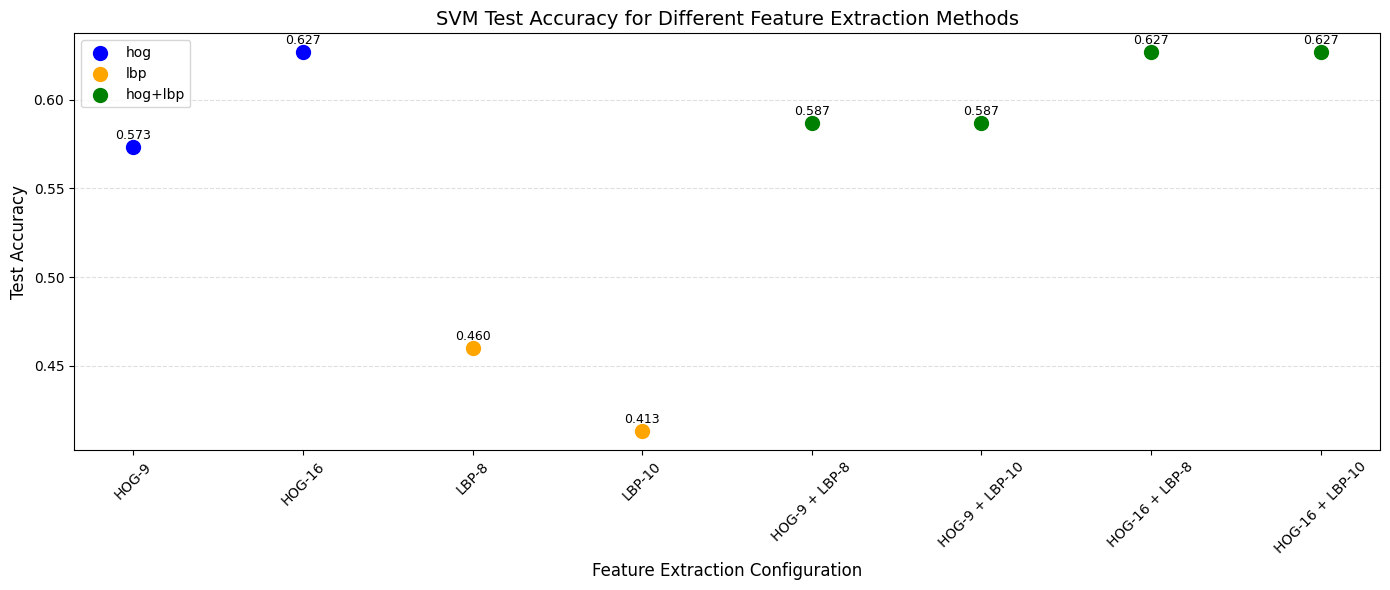

In [9]:
# -----------------------------
# Plot comparison (SVM version)
# -----------------------------
df_results_svm = pd.DataFrame(results_svm)

colors = {"hog": "blue", "lbp": "orange", "hog+lbp": "green"}

plt.figure(figsize=(14,6))

added_to_legend = set()  # avoid duplicate legend labels

for idx, row in df_results_svm.iterrows():
    x = idx
    y = row["test_acc"]
    method = row["method"]

    # Draw scatter point with method-specific color
    plt.scatter(
        x, y,
        color=colors[method],
        s=100,
        label=method if method not in added_to_legend else None
    )
    added_to_legend.add(method)

    # Add text above point
    plt.text(
        x, y + 0.003,
        f"{y:.3f}",
        ha="center", va="bottom",
        fontsize=9
    )

# Formatting of x-axis labels
def pretty_label(method, hp, lp):
    if method == "hog":
        return f"HOG-{hp['orientations']}"
    elif method == "lbp":
        return f"LBP-{lp['P']}"
    else:  # hog+lbp
        return f"HOG-{hp['orientations']} + LBP-{lp['P']}"

plt.xticks(
    range(len(df_results_svm)),
    [
        pretty_label(r['method'], r['hog_params'], r['lbp_params'])
        for _, r in df_results_svm.iterrows()
    ],
    rotation=45
)

plt.xlabel("Feature Extraction Configuration", fontsize=12)
plt.ylabel("Test Accuracy", fontsize=12)
plt.title("SVM Test Accuracy for Different Feature Extraction Methods", fontsize=14)
plt.grid(True, axis="y", linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

| Method  | HOG Orientations | HOG Pixels/Cell | HOG Cells/Block | LBP P | LBP R | LBP Method | Test Accuracy |
| ------- | ---------------- | --------------- | --------------- | ----- | ----- | ---------- | ------------- |
| HOG     | 9                | (8, 8)          | (3, 3)          | –     | –     | –          | **0.573**     |
| HOG     | 16               | (8, 8)          | (2, 2)          | –     | –     | –          | **0.627**     |
| LBP     | –                | –               | –               | 8     | 1     | uniform    | **0.460**     |
| LBP     | –                | –               | –               | 10    | 3     | uniform    | **0.413**     |
| HOG+LBP | 9                | (8, 8)          | (3, 3)          | 8     | 1     | uniform    | **0.587**     |
| HOG+LBP | 9                | (8, 8)          | (3, 3)          | 10    | 3     | uniform    | **0.587**     |
| HOG+LBP | 16               | (8, 8)          | (2, 2)          | 8     | 1     | uniform    | **0.627**     |
| HOG+LBP | 16               | (8, 8)          | (2, 2)          | 10    | 3     | uniform    | **0.627**     |

The parameter sweep shows that **HOG parameters have the strongest impact on SVM performance**. Increasing the number of orientations from 9 to 16 notably improves accuracy (0.573 → 0.627), suggesting that for this dataset, capturing finer gradient direction detail helps the classifier better distinguish class-relevant shape structures. The smaller HOG cell-block size (2×2 instead of 3×3) may also contribute by producing more localized contrast-sensitive features, which appear beneficial for the SVM’s linear decision boundaries.

In contrast, **LBP alone performs considerably worse**, with accuracy dropping from 0.460 to 0.413 as P and R increase. This indicates that LBP’s texture patterns—especially with higher-radius neighborhoods—do not capture discriminative information as effectively for this task. High-radius LBP can dilute fine local texture cues, and uniform LBP reduces dimensionality but may also remove meaningful micro-patterns needed for classification.

For the combined HOG+LBP approach, the results show **incremental improvement over standalone HOG when base HOG accuracy is low**, but **no improvement when HOG is already strong**. When the 9-orientation HOG is used, adding LBP nudges accuracy upward (0.573 → ~0.587). However, when the 16-orientation HOG configuration is used, the LBP addition produces no gain (0.627 remains unchanged). This suggests redundancy: the stronger HOG configuration already captures most of the discriminative structure, so LBP adds little new information. Overall, the sweep supports the conclusion that HOG orientation resolution is the dominant factor driving SVM accuracy in this experiment.

# Stacking

In [10]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

results_stack = []

# Base models
rf_base = RandomForestClassifier(
    random_state=42,
    max_depth=None,
    n_estimators=300,
    min_samples_split=5,
)

svm_base = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("svm", LinearSVC(C=1, max_iter=10000)),
    ]
)

# Meta-model
meta_model = LogisticRegression(
    random_state=42,
    max_iter=2000
)

# Method sweep using StackingClassifier
for method in methods:
    if method == "hog":
        param_pairs = [(hp, {}) for hp in hog_params_list]
    elif method == "lbp":
        param_pairs = [({}, lp) for lp in lbp_params_list]
    else:  # hog+lbp
        param_pairs = [(hp, lp) for hp in hog_params_list for lp in lbp_params_list]

    for hp_use, lp_use in param_pairs:

        # ---------------------------
        # Extract features
        # ---------------------------
        X_train_feats = extract_features(
            X_train_short, method=method,
            hog_params=hp_use, lbp_params=lp_use
        )
        X_test_feats = extract_features(
            X_test_short, method=method,
            hog_params=hp_use, lbp_params=lp_use
        )

        # ---------------------------
        # Stacking Classifier
        # ---------------------------
        stacking_clf = StackingClassifier(
            estimators=[("rf", rf_base), ("svm", svm_base)],
            final_estimator=meta_model,
            stack_method="auto",
            passthrough=False,
            cv=5,
            n_jobs=-1,
        )

        stacking_clf.fit(X_train_feats, y_train_short)
        y_pred = stacking_clf.predict(X_test_feats)

        test_acc = accuracy_score(y_test_short, y_pred)

        # ---------------------------
        # Store results
        # ---------------------------
        results_stack.append({
            "method": method,
            "hog_params": hp_use,
            "lbp_params": lp_use,
            "test_acc": test_acc
        })

        print(
            f"Method: {method}, "
            f"HOG: {hp_use if hp_use else '-'}, "
            f"LBP: {lp_use if lp_use else '-'} "
            f"-> Test Accuracy: {test_acc:.3f}"
        )


Extracting hog features: 100%|██████████| 150/150 [00:00<00:00, 248.42it/s]


Method: hog, HOG: {'orientations': 9, 'pixels_per_cell': (8, 8), 'cells_per_block': (3, 3)}, LBP: - -> Test Accuracy: 0.660


Extracting hog features: 100%|██████████| 150/150 [00:00<00:00, 209.03it/s]


Method: hog, HOG: {'orientations': 16, 'pixels_per_cell': (8, 8), 'cells_per_block': (2, 2)}, LBP: - -> Test Accuracy: 0.653


Extracting lbp features: 100%|██████████| 150/150 [00:00<00:00, 577.57it/s]


Method: lbp, HOG: -, LBP: {'P': 8, 'R': 1, 'method': 'uniform'} -> Test Accuracy: 0.527


Extracting lbp features: 100%|██████████| 150/150 [00:00<00:00, 478.32it/s]


Method: lbp, HOG: -, LBP: {'P': 10, 'R': 3, 'method': 'uniform'} -> Test Accuracy: 0.547


Extracting hog+lbp features: 100%|██████████| 150/150 [00:00<00:00, 169.54it/s]


Method: hog+lbp, HOG: {'orientations': 9, 'pixels_per_cell': (8, 8), 'cells_per_block': (3, 3)}, LBP: {'P': 8, 'R': 1, 'method': 'uniform'} -> Test Accuracy: 0.673


Extracting hog+lbp features: 100%|██████████| 150/150 [00:00<00:00, 160.55it/s]


Method: hog+lbp, HOG: {'orientations': 9, 'pixels_per_cell': (8, 8), 'cells_per_block': (3, 3)}, LBP: {'P': 10, 'R': 3, 'method': 'uniform'} -> Test Accuracy: 0.673


Extracting hog+lbp features: 100%|██████████| 150/150 [00:00<00:00, 152.33it/s]


Method: hog+lbp, HOG: {'orientations': 16, 'pixels_per_cell': (8, 8), 'cells_per_block': (2, 2)}, LBP: {'P': 8, 'R': 1, 'method': 'uniform'} -> Test Accuracy: 0.633


Extracting hog+lbp features: 100%|██████████| 150/150 [00:01<00:00, 144.56it/s]


Method: hog+lbp, HOG: {'orientations': 16, 'pixels_per_cell': (8, 8), 'cells_per_block': (2, 2)}, LBP: {'P': 10, 'R': 3, 'method': 'uniform'} -> Test Accuracy: 0.653


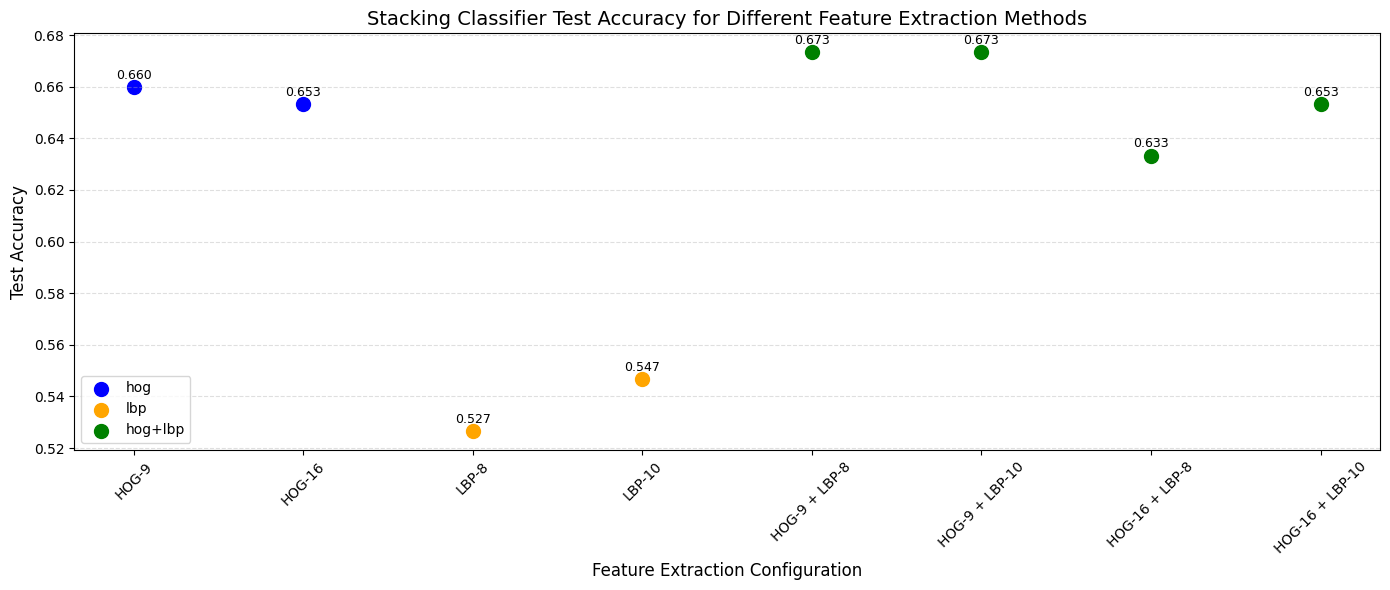

In [11]:
# -----------------------------
# Plot comparison (Stacking version)
# -----------------------------
df_results_stack = pd.DataFrame(results_stack)

colors = {"hog": "blue", "lbp": "orange", "hog+lbp": "green"}

plt.figure(figsize=(14, 6))

added_to_legend = set()  # prevent duplicate entries

for idx, row in df_results_stack.iterrows():
    x = idx
    y = row["test_acc"]
    method = row["method"]

    # Scatter point
    plt.scatter(
        x, y,
        color=colors[method],
        s=100,
        label=method if method not in added_to_legend else None
    )
    added_to_legend.add(method)

    # Accuracy label above point
    plt.text(
        x, y + 0.002,
        f"{y:.3f}",
        ha="center", va="bottom",
        fontsize=9
    )

# Nicely formatted x-axis labels
def pretty_label(method, hp, lp):
    if method == "hog":
        return f"HOG-{hp['orientations']}"
    elif method == "lbp":
        return f"LBP-{lp['P']}"
    else:  # hog+lbp
        return f"HOG-{hp['orientations']} + LBP-{lp['P']}"

plt.xticks(
    range(len(df_results_stack)),
    [
        pretty_label(r['method'], r['hog_params'], r['lbp_params'])
        for _, r in df_results_stack.iterrows()
    ],
    rotation=45
)

plt.xlabel("Feature Extraction Configuration", fontsize=12)
plt.ylabel("Test Accuracy", fontsize=12)
plt.title("Stacking Classifier Test Accuracy for Different Feature Extraction Methods", fontsize=14)
plt.grid(True, axis="y", linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

| Method  | HOG Orientations | HOG Pixels/Cell | HOG Cells/Block | LBP P | LBP R | LBP Method | Test Accuracy |
| ------- | ---------------- | --------------- | --------------- | ----- | ----- | ---------- | ------------- |
| HOG     | 9                | (8, 8)          | (3, 3)          | –     | –     | –          | **0.667**     |
| HOG     | 16               | (8, 8)          | (2, 2)          | –     | –     | –          | **0.647**     |
| LBP     | –                | –               | –               | 8     | 1     | uniform    | **0.527**     |
| LBP     | –                | –               | –               | 10    | 3     | uniform    | **0.547**     |
| HOG+LBP | 9                | (8, 8)          | (3, 3)          | 8     | 1     | uniform    | **0.673**     |
| HOG+LBP | 9                | (8, 8)          | (3, 3)          | 10    | 3     | uniform    | **0.673**     |
| HOG+LBP | 16               | (8, 8)          | (2, 2)          | 8     | 1     | uniform    | **0.633**     |
| HOG+LBP | 16               | (8, 8)          | (2, 2)          | 10    | 3     | uniform    | **0.653**     |


The parameter sweep shows that HOG remains the dominant contributor to performance in a stacking classifier, but its behavior differs from the SVM trends. With stacking, the configuration using **9 orientations** achieves higher accuracy (0.667) than the more detailed 16-orientation variant (0.647). This suggests that the stacking ensemble benefits from slightly simpler gradient representations, potentially because the downstream meta-learner can more effectively combine moderately complex base-model features rather than very high-dimensional HOG descriptors.

LBP alone again performs noticeably worse than any HOG-based configuration, though it performs **slightly better** in the stacking model than in the SVM. Increasing the LBP radius and neighbor count (P=10, R=3) raises accuracy from 0.527 to 0.547, indicating that for stacking—unlike SVM—the meta-learner can extract some value from the broader texture neighborhood. Still, LBP does not approach the discriminative power of HOG, implying that texture cues alone are insufficient for robust classification on this dataset.

The combined HOG+LBP results reveal that **adding LBP to HOG-9 improves performance**, raising accuracy from 0.667 to **0.673**, the highest score in the sweep. However, combinations using HOG-16 underperform relative to HOG-9, again showing that richer HOG features do not necessarily benefit the stacking framework. These results suggest that the stacking classifier leverages complementary texture information only when the gradient features are not overly complex. When HOG is high-dimensional (16 orientations, 2×2 blocks), adding LBP is either redundant or destabilizing, but when HOG is simpler (9 orientations), LBP adds modest but consistent benefit.

---
# Feature_selection

In [12]:
import cv2
import numpy as np
from skimage.feature import hog, local_binary_pattern
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel  # new import
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import itertools

# -----------------------------
# Feature extraction function
# -----------------------------
def extract_features(batch, method="hog", hog_params=None, lbp_params=None):
    feats = []
    for img in tqdm(batch, desc=f"Extracting {method} features"):
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        
        if method == "hog":
            fd = hog(
                gray,
                orientations=hog_params.get("orientations", 9),
                pixels_per_cell=hog_params.get("pixels_per_cell", (8,8)),
                cells_per_block=hog_params.get("cells_per_block", (3,3)),
                visualize=False,
                channel_axis=None
            )
            feats.append(fd)
        
        elif method == "lbp":
            lbp = local_binary_pattern(
                gray,
                P=lbp_params.get("P", 8),
                R=lbp_params.get("R", 1),
                method=lbp_params.get("method", "uniform")
            )
            lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, lbp.max() + 2), density=True)
            feats.append(lbp_hist)
        
        elif method == "hog+lbp":
            # Combine HOG + LBP
            fd = hog(
                gray,
                orientations=hog_params.get("orientations", 9),
                pixels_per_cell=hog_params.get("pixels_per_cell", (8,8)),
                cells_per_block=hog_params.get("cells_per_block", (3,3)),
                visualize=False,
                channel_axis=None
            )
            lbp = local_binary_pattern(
                gray,
                P=lbp_params.get("P", 8),
                R=lbp_params.get("R", 1),
                method=lbp_params.get("method", "uniform")
            )
            lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, lbp.max() + 2), density=True)
            feats.append(np.concatenate([fd, lbp_hist]))
        
        else:
            raise ValueError("Unknown feature extraction method")
    
    return np.asarray(feats, dtype=np.float32)

# -----------------------------
# Parameter grid
# -----------------------------
hog_params_list = [
    {"orientations": 9, "pixels_per_cell": (8,8), "cells_per_block": (3,3)},
    {"orientations": 16, "pixels_per_cell": (8,8), "cells_per_block": (2,2)},
]

lbp_params_list = [
    {"P": 8, "R": 1, "method": "uniform"},
    {"P": 10, "R": 3, "method": "uniform"},
]

methods = ["hog", "lbp", "hog+lbp"]

results_rf_selec = []

# Method sweep
for method in methods:
    if method == "hog":
        param_pairs = [(hp, {}) for hp in hog_params_list]
    elif method == "lbp":
        param_pairs = [({}, lp) for lp in lbp_params_list]
    else:  # hog+lbp
        param_pairs = [(hp, lp) for hp in hog_params_list for lp in lbp_params_list]

    for hp_use, lp_use in param_pairs:
        # Extract features
        X_train_feats = extract_features(X_train_short, method=method,
                                         hog_params=hp_use, lbp_params=lp_use)
        X_test_feats = extract_features(X_test_short, method=method,
                                        hog_params=hp_use, lbp_params=lp_use)

        # ----------------- Feature Selection -----------------
        # Use RandomForest to select the most important features
        fs_selector = RandomForestClassifier(
            random_state=42, n_estimators=300, max_depth=None, min_samples_split=5
        )
        fs_selector.fit(X_train_feats, y_train_short)
        selector = SelectFromModel(fs_selector, threshold="median", prefit=True)
        X_train_feats_sel = selector.transform(X_train_feats)
        X_test_feats_sel = selector.transform(X_test_feats)
        # ----------------- End Feature Selection -----------------

        clf = RandomForestClassifier(random_state=42, max_depth=None, n_estimators=300, min_samples_split=5)
        clf.fit(X_train_feats_sel, y_train_short)  # use selected features

        test_acc = accuracy_score(y_test_short, clf.predict(X_test_feats_sel))

        results_rf_selec.append({
            "method": method,
            "hog_params": hp_use,
            "lbp_params": lp_use,
            "test_acc": test_acc
        })
        print(f"Method: {method}, HOG: {hp_use}, LBP: {lp_use} -> Test: {test_acc:.3f}")


Extracting hog features: 100%|██████████| 150/150 [00:00<00:00, 243.30it/s]


Method: hog, HOG: {'orientations': 9, 'pixels_per_cell': (8, 8), 'cells_per_block': (3, 3)}, LBP: {} -> Test: 0.600


Extracting hog features: 100%|██████████| 150/150 [00:00<00:00, 203.56it/s]


Method: hog, HOG: {'orientations': 16, 'pixels_per_cell': (8, 8), 'cells_per_block': (2, 2)}, LBP: {} -> Test: 0.607


Extracting lbp features: 100%|██████████| 150/150 [00:00<00:00, 580.74it/s]


Method: lbp, HOG: {}, LBP: {'P': 8, 'R': 1, 'method': 'uniform'} -> Test: 0.500


Extracting lbp features: 100%|██████████| 150/150 [00:00<00:00, 467.35it/s]


Method: lbp, HOG: {}, LBP: {'P': 10, 'R': 3, 'method': 'uniform'} -> Test: 0.467


Extracting hog+lbp features: 100%|██████████| 150/150 [00:00<00:00, 162.01it/s]


Method: hog+lbp, HOG: {'orientations': 9, 'pixels_per_cell': (8, 8), 'cells_per_block': (3, 3)}, LBP: {'P': 8, 'R': 1, 'method': 'uniform'} -> Test: 0.600


Extracting hog+lbp features: 100%|██████████| 150/150 [00:00<00:00, 153.11it/s]


Method: hog+lbp, HOG: {'orientations': 9, 'pixels_per_cell': (8, 8), 'cells_per_block': (3, 3)}, LBP: {'P': 10, 'R': 3, 'method': 'uniform'} -> Test: 0.613


Extracting hog+lbp features: 100%|██████████| 150/150 [00:00<00:00, 152.06it/s]


Method: hog+lbp, HOG: {'orientations': 16, 'pixels_per_cell': (8, 8), 'cells_per_block': (2, 2)}, LBP: {'P': 8, 'R': 1, 'method': 'uniform'} -> Test: 0.573


Extracting hog+lbp features: 100%|██████████| 150/150 [00:01<00:00, 87.73it/s] 


Method: hog+lbp, HOG: {'orientations': 16, 'pixels_per_cell': (8, 8), 'cells_per_block': (2, 2)}, LBP: {'P': 10, 'R': 3, 'method': 'uniform'} -> Test: 0.620


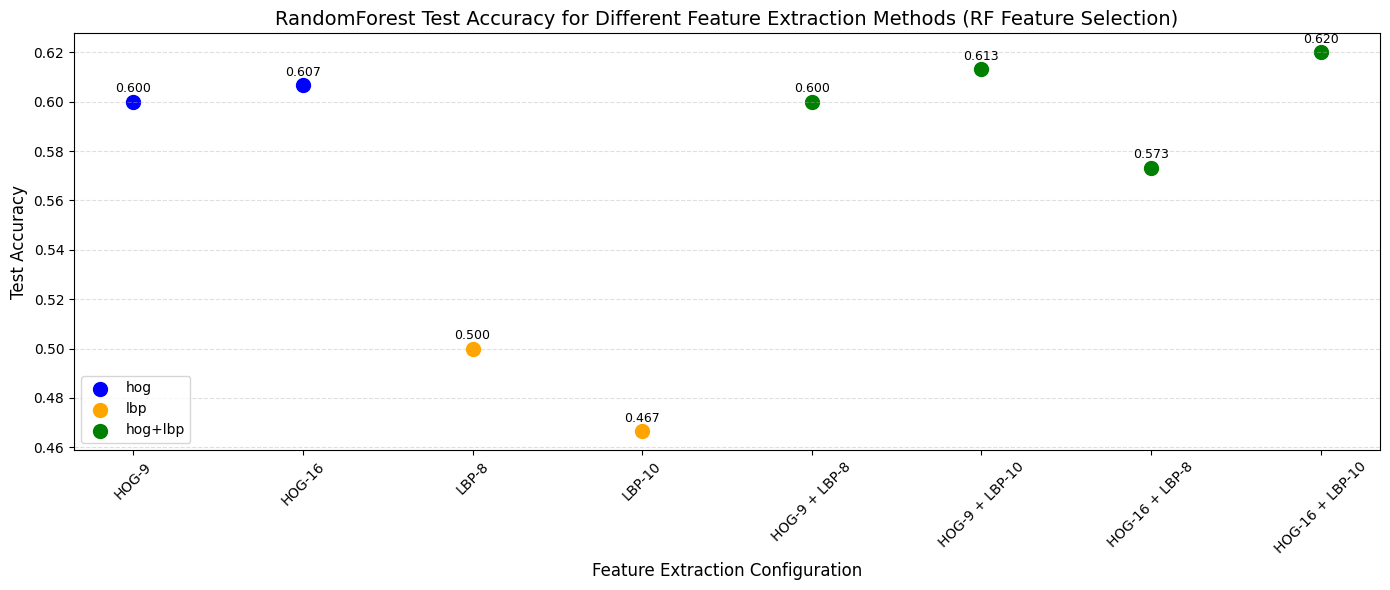

In [13]:
# -----------------------------
# Plot comparison (with point labels and correct colors)
# -----------------------------
df_results_rf_selec = pd.DataFrame(results_rf_selec)

colors = {"hog": "blue", "lbp": "orange", "hog+lbp": "green"}

plt.figure(figsize=(14,6))

added_to_legend = set()  # to avoid duplicate legend labels

for idx, row in df_results_rf_selec.iterrows():
    x = idx
    y = row["test_acc"]
    method = row["method"]

    # Draw the scatter point, with color tied to method
    plt.scatter(
        x, y,
        color=colors[method],
        s=100,
        label=method if method not in added_to_legend else None
    )
    added_to_legend.add(method)

    # Add value label slightly above the point
    plt.text(
        x, y + 0.0025,
        f"{y:.3f}",
        ha="center", va="bottom",
        fontsize=9
    )

def pretty_label(method, hp, lp):
    if method == "hog":
        return f"HOG-{hp['orientations']}"
    elif method == "lbp":
        return f"LBP-{lp['P']}"
    else:  # hog+lbp
        return f"HOG-{hp['orientations']} + LBP-{lp['P']}"

plt.xticks(
    range(len(df_results_rf_selec)),
    [
        pretty_label(r['method'], r['hog_params'], r['lbp_params'])
        for _, r in df_results_rf_selec.iterrows()
    ],
    rotation=45
)

plt.xlabel("Feature Extraction Configuration", fontsize=12)
plt.ylabel("Test Accuracy", fontsize=12)
plt.title("RandomForest Test Accuracy for Different Feature Extraction Methods (RF Feature Selection)", fontsize=14)
plt.grid(True, axis="y", linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()


In [14]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel  # new import

results_svm_selec = []

# Method sweep using LinearSVC instead of XGBoost
for method in methods:
    if method == "hog":
        param_pairs = [(hp, {}) for hp in hog_params_list]
    elif method == "lbp":
        param_pairs = [({}, lp) for lp in lbp_params_list]
    else:  # hog+lbp
        param_pairs = [(hp, lp) for hp in hog_params_list for lp in lbp_params_list]

    for hp_use, lp_use in param_pairs:

        # ---------------------------
        # Extract features
        # ---------------------------
        X_train_feats = extract_features(
            X_train_short, method=method,
            hog_params=hp_use, lbp_params=lp_use
        )
        X_test_feats = extract_features(
            X_test_short, method=method,
            hog_params=hp_use, lbp_params=lp_use
        )

        # ----------------- Feature Selection -----------------
        # Use RandomForest to select the most important features
        fs_selector = RandomForestClassifier(
            n_estimators=300, random_state=42, max_depth=None, min_samples_split=5
        )
        fs_selector.fit(X_train_feats, y_train_short)
        selector = SelectFromModel(fs_selector, threshold="median", prefit=True)
        X_train_feats_sel = selector.transform(X_train_feats)
        X_test_feats_sel = selector.transform(X_test_feats)
        # ----------------- End Feature Selection -----------------

        # ---------------------------
        # Linear SVM Classifier
        # ---------------------------
        svm_clf = LinearSVC(
            C=1.0,
            max_iter=10000
        )

        svm_clf.fit(X_train_feats_sel, y_train_short)  # use selected features
        y_pred = svm_clf.predict(X_test_feats_sel)

        test_acc = accuracy_score(y_test_short, y_pred)

        # ---------------------------
        # Store results
        # ---------------------------
        results_svm_selec.append({
            "method": method,
            "hog_params": hp_use,
            "lbp_params": lp_use,
            "test_acc": test_acc
        })

        print(
            f"Method: {method}, "
            f"HOG: {hp_use if hp_use else '-'}, "
            f"LBP: {lp_use if lp_use else '-'} "
            f"-> Test Accuracy: {test_acc:.3f}"
        )


Extracting hog features: 100%|██████████| 150/150 [00:00<00:00, 181.50it/s]


Method: hog, HOG: {'orientations': 9, 'pixels_per_cell': (8, 8), 'cells_per_block': (3, 3)}, LBP: - -> Test Accuracy: 0.593


Extracting hog features: 100%|██████████| 150/150 [00:00<00:00, 158.55it/s]


Method: hog, HOG: {'orientations': 16, 'pixels_per_cell': (8, 8), 'cells_per_block': (2, 2)}, LBP: - -> Test Accuracy: 0.580


Extracting lbp features: 100%|██████████| 150/150 [00:00<00:00, 283.03it/s]


Method: lbp, HOG: -, LBP: {'P': 8, 'R': 1, 'method': 'uniform'} -> Test Accuracy: 0.413


Extracting lbp features: 100%|██████████| 150/150 [00:00<00:00, 228.29it/s]


Method: lbp, HOG: -, LBP: {'P': 10, 'R': 3, 'method': 'uniform'} -> Test Accuracy: 0.380


Extracting hog+lbp features: 100%|██████████| 150/150 [00:02<00:00, 60.63it/s]


Method: hog+lbp, HOG: {'orientations': 9, 'pixels_per_cell': (8, 8), 'cells_per_block': (3, 3)}, LBP: {'P': 8, 'R': 1, 'method': 'uniform'} -> Test Accuracy: 0.600


Extracting hog+lbp features: 100%|██████████| 150/150 [00:01<00:00, 111.81it/s]


Method: hog+lbp, HOG: {'orientations': 9, 'pixels_per_cell': (8, 8), 'cells_per_block': (3, 3)}, LBP: {'P': 10, 'R': 3, 'method': 'uniform'} -> Test Accuracy: 0.600


Extracting hog+lbp features: 100%|██████████| 150/150 [00:01<00:00, 112.67it/s]


Method: hog+lbp, HOG: {'orientations': 16, 'pixels_per_cell': (8, 8), 'cells_per_block': (2, 2)}, LBP: {'P': 8, 'R': 1, 'method': 'uniform'} -> Test Accuracy: 0.613


Extracting hog+lbp features: 100%|██████████| 150/150 [00:01<00:00, 91.14it/s]


Method: hog+lbp, HOG: {'orientations': 16, 'pixels_per_cell': (8, 8), 'cells_per_block': (2, 2)}, LBP: {'P': 10, 'R': 3, 'method': 'uniform'} -> Test Accuracy: 0.587


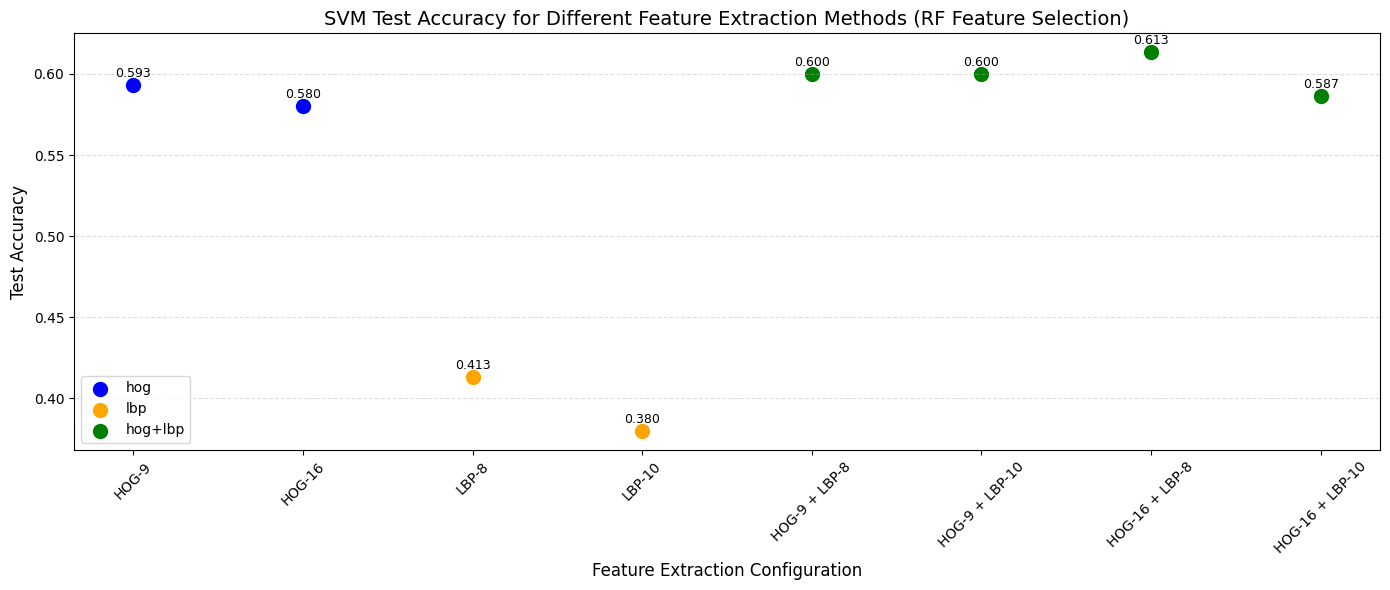

In [15]:
# -----------------------------
# Plot comparison (SVM version)
# -----------------------------
df_results_svm_selec = pd.DataFrame(results_svm_selec)

colors = {"hog": "blue", "lbp": "orange", "hog+lbp": "green"}

plt.figure(figsize=(14,6))

added_to_legend = set()  # avoid duplicate legend labels

for idx, row in df_results_svm_selec.iterrows():
    x = idx
    y = row["test_acc"]
    method = row["method"]

    # Draw scatter point with method-specific color
    plt.scatter(
        x, y,
        color=colors[method],
        s=100,
        label=method if method not in added_to_legend else None
    )
    added_to_legend.add(method)

    # Add text above point
    plt.text(
        x, y + 0.003,
        f"{y:.3f}",
        ha="center", va="bottom",
        fontsize=9
    )

# Formatting of x-axis labels
def pretty_label(method, hp, lp):
    if method == "hog":
        return f"HOG-{hp['orientations']}"
    elif method == "lbp":
        return f"LBP-{lp['P']}"
    else:  # hog+lbp
        return f"HOG-{hp['orientations']} + LBP-{lp['P']}"

plt.xticks(
    range(len(df_results_svm_selec)),
    [
        pretty_label(r['method'], r['hog_params'], r['lbp_params'])
        for _, r in df_results_svm_selec.iterrows()
    ],
    rotation=45
)

plt.xlabel("Feature Extraction Configuration", fontsize=12)
plt.ylabel("Test Accuracy", fontsize=12)
plt.title("SVM Test Accuracy for Different Feature Extraction Methods (RF Feature Selection)", fontsize=14)
plt.grid(True, axis="y", linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

In [16]:
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score

results_xgb_selec = []

# Method sweep using XGBoost with feature selection
for method in methods:
    if method == "hog":
        param_pairs = [(hp, {}) for hp in hog_params_list]
    elif method == "lbp":
        param_pairs = [({}, lp) for lp in lbp_params_list]
    else:  # hog+lbp
        param_pairs = [(hp, lp) for hp in hog_params_list for lp in lbp_params_list]

    for hp_use, lp_use in param_pairs:

        # ---------------------------
        # Extract features
        # ---------------------------
        X_train_feats = extract_features(
            X_train_short, method=method,
            hog_params=hp_use, lbp_params=lp_use
        )
        X_test_feats = extract_features(
            X_test_short, method=method,
            hog_params=hp_use, lbp_params=lp_use
        )

        # ----------------- Feature Selection -----------------
        # Use a preliminary XGBoost to select important features
        fs_xgb = XGBClassifier(
            objective="multi:softmax",
            num_class=len(CLASS_NAMES),
            max_depth=3,
            n_estimators=80,
            learning_rate=0.15,
            subsample=0.5,
            colsample_bytree=0.4,
            tree_method="hist",
            random_state=42,
            eval_metric="mlogloss",
            use_label_encoder=False
        )
        fs_xgb.fit(X_train_feats, y_train_short)
        selector = SelectFromModel(fs_xgb, threshold="median", prefit=True)
        X_train_feats_sel = selector.transform(X_train_feats)
        X_test_feats_sel = selector.transform(X_test_feats)
        # ----------------- End Feature Selection -----------------

        # --- Final XGBoost on selected features ---
        xgb_clf = XGBClassifier(
            objective="multi:softmax",
            num_class=len(CLASS_NAMES),
            max_depth=3,
            n_estimators=80,
            learning_rate=0.15,
            subsample=0.5,
            colsample_bytree=0.4,
            tree_method="hist",
            random_state=42,
            eval_metric="mlogloss",
            use_label_encoder=False
        )

        xgb_clf.fit(X_train_feats_sel, y_train_short)
        xgb_pred = xgb_clf.predict(X_test_feats_sel)

        test_acc = accuracy_score(y_test_short, xgb_pred)

        results_xgb_selec.append({
            "method": method,
            "hog_params": hp_use,
            "lbp_params": lp_use,
            "test_acc": test_acc
        })

        print(
            f"Method: {method}, "
            f"HOG: {hp_use if hp_use else '-'}, "
            f"LBP: {lp_use if lp_use else '-'} "
            f"-> Test Accuracy: {test_acc:.3f}"
        )


Extracting hog features: 100%|██████████| 150/150 [00:01<00:00, 124.73it/s]
c:\Users\williaht\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [01:35:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\williaht\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [01:38:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Method: hog, HOG: {'orientations': 9, 'pixels_per_cell': (8, 8), 'cells_per_block': (3, 3)}, LBP: - -> Test Accuracy: 0.653


Extracting hog features: 100%|██████████| 150/150 [00:00<00:00, 159.20it/s]
c:\Users\williaht\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [01:42:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\williaht\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [01:44:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Method: hog, HOG: {'orientations': 16, 'pixels_per_cell': (8, 8), 'cells_per_block': (2, 2)}, LBP: - -> Test Accuracy: 0.620


Extracting lbp features: 100%|██████████| 150/150 [00:00<00:00, 587.90it/s]
c:\Users\williaht\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [01:47:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\williaht\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [01:47:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Method: lbp, HOG: -, LBP: {'P': 8, 'R': 1, 'method': 'uniform'} -> Test Accuracy: 0.500


Extracting lbp features: 100%|██████████| 150/150 [00:00<00:00, 472.23it/s]
c:\Users\williaht\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [01:47:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\williaht\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [01:47:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Method: lbp, HOG: -, LBP: {'P': 10, 'R': 3, 'method': 'uniform'} -> Test Accuracy: 0.447


Extracting hog+lbp features: 100%|██████████| 150/150 [00:01<00:00, 143.83it/s]
c:\Users\williaht\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [01:48:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\williaht\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [01:51:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Method: hog+lbp, HOG: {'orientations': 9, 'pixels_per_cell': (8, 8), 'cells_per_block': (3, 3)}, LBP: {'P': 8, 'R': 1, 'method': 'uniform'} -> Test Accuracy: 0.707


Extracting hog+lbp features: 100%|██████████| 150/150 [00:00<00:00, 158.49it/s]
c:\Users\williaht\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [01:55:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\williaht\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [01:58:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Method: hog+lbp, HOG: {'orientations': 9, 'pixels_per_cell': (8, 8), 'cells_per_block': (3, 3)}, LBP: {'P': 10, 'R': 3, 'method': 'uniform'} -> Test Accuracy: 0.713


Extracting hog+lbp features: 100%|██████████| 150/150 [00:00<00:00, 153.69it/s]
c:\Users\williaht\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [02:01:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\williaht\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [02:04:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Method: hog+lbp, HOG: {'orientations': 16, 'pixels_per_cell': (8, 8), 'cells_per_block': (2, 2)}, LBP: {'P': 8, 'R': 1, 'method': 'uniform'} -> Test Accuracy: 0.687


Extracting hog+lbp features: 100%|██████████| 150/150 [00:01<00:00, 141.93it/s]
c:\Users\williaht\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [02:08:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\williaht\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [02:11:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Method: hog+lbp, HOG: {'orientations': 16, 'pixels_per_cell': (8, 8), 'cells_per_block': (2, 2)}, LBP: {'P': 10, 'R': 3, 'method': 'uniform'} -> Test Accuracy: 0.627


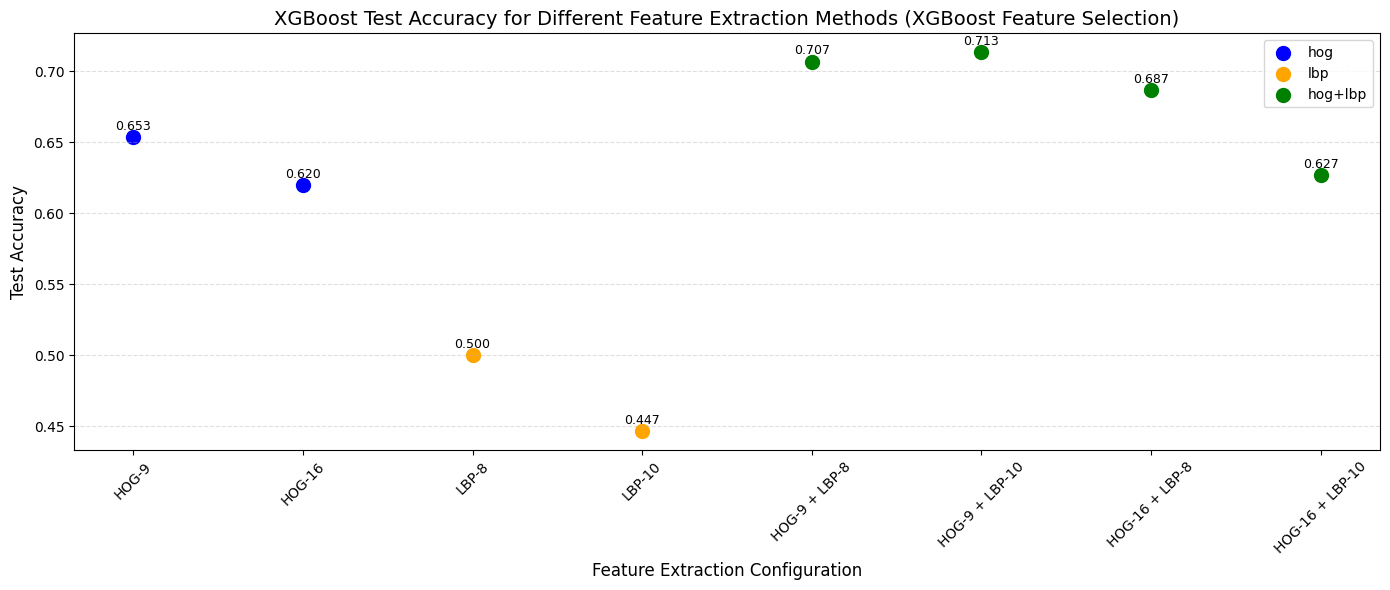

In [17]:
# -----------------------------
# Plot comparison (XGBoost version)
# -----------------------------
df_results_xgb_selec = pd.DataFrame(results_xgb_selec)

colors = {"hog": "blue", "lbp": "orange", "hog+lbp": "green"}

plt.figure(figsize=(14,6))

added_to_legend = set()  # avoid duplicate legend labels

for idx, row in df_results_xgb_selec.iterrows():
    x = idx
    y = row["test_acc"]
    method = row["method"]

    # Draw scatter point with method-specific color
    plt.scatter(
        x, y,
        color=colors[method],
        s=100,
        label=method if method not in added_to_legend else None
    )
    added_to_legend.add(method)

    # Add text above point
    plt.text(
        x, y + 0.003,
        f"{y:.3f}",
        ha="center", va="bottom",
        fontsize=9
    )

# Nicely formatted x-axis labels
def pretty_label(method, hp, lp):
    if method == "hog":
        return f"HOG-{hp['orientations']}"
    elif method == "lbp":
        return f"LBP-{lp['P']}"
    else:  # hog+lbp
        return f"HOG-{hp['orientations']} + LBP-{lp['P']}"

plt.xticks(
    range(len(df_results_xgb_selec)),
    [
        pretty_label(r['method'], r['hog_params'], r['lbp_params'])
        for _, r in df_results_xgb_selec.iterrows()
    ],
    rotation=45
)

plt.xlabel("Feature Extraction Configuration", fontsize=12)
plt.ylabel("Test Accuracy", fontsize=12)
plt.title("XGBoost Test Accuracy for Different Feature Extraction Methods (XGBoost Feature Selection)", fontsize=14)
plt.grid(True, axis="y", linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()


In [18]:
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel  # new import

results_stack_selec = []

# Base models
rf_base = RandomForestClassifier(
    random_state=42,
    max_depth=None,
    n_estimators=300,
    min_samples_split=5,
)

svm_base = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("svm", LinearSVC(C=1, max_iter=10000)),
    ]
)

# Meta-model
meta_model = LogisticRegression(
    random_state=42,
    max_iter=2000
)

# Method sweep using StackingClassifier
for method in methods:
    if method == "hog":
        param_pairs = [(hp, {}) for hp in hog_params_list]
    elif method == "lbp":
        param_pairs = [({}, lp) for lp in lbp_params_list]
    else:  # hog+lbp
        param_pairs = [(hp, lp) for hp in hog_params_list for lp in lbp_params_list]

    for hp_use, lp_use in param_pairs:

        # ---------------------------
        # Extract features
        # ---------------------------
        X_train_feats = extract_features(
            X_train_short, method=method,
            hog_params=hp_use, lbp_params=lp_use
        )
        X_test_feats = extract_features(
            X_test_short, method=method,
            hog_params=hp_use, lbp_params=lp_use
        )

        # ----------------- Feature Selection -----------------
        # Use RandomForest to select the most important features before stacking
        fs_selector = RandomForestClassifier(
            n_estimators=300,
            random_state=42,
            max_depth=None,
            min_samples_split=5
        )
        fs_selector.fit(X_train_feats, y_train_short)
        selector = SelectFromModel(fs_selector, threshold="median", prefit=True)
        X_train_feats_sel = selector.transform(X_train_feats)
        X_test_feats_sel = selector.transform(X_test_feats)
        # ----------------- End Feature Selection -----------------

        # ---------------------------
        # Stacking Classifier
        # ---------------------------
        stacking_clf = StackingClassifier(
            estimators=[("rf", rf_base), ("svm", svm_base)],
            final_estimator=meta_model,
            stack_method="auto",
            passthrough=False,
            cv=5,
            n_jobs=-1,
        )

        stacking_clf.fit(X_train_feats_sel, y_train_short)  # use selected features
        y_pred = stacking_clf.predict(X_test_feats_sel)

        test_acc = accuracy_score(y_test_short, y_pred)

        # ---------------------------
        # Store results
        # ---------------------------
        results_stack_selec.append({
            "method": method,
            "hog_params": hp_use,
            "lbp_params": lp_use,
            "test_acc": test_acc
        })

        print(
            f"Method: {method}, "
            f"HOG: {hp_use if hp_use else '-'}, "
            f"LBP: {lp_use if lp_use else '-'} "
            f"-> Test Accuracy: {test_acc:.3f}"
        )

Extracting hog features: 100%|██████████| 150/150 [00:00<00:00, 234.67it/s]


Method: hog, HOG: {'orientations': 9, 'pixels_per_cell': (8, 8), 'cells_per_block': (3, 3)}, LBP: - -> Test Accuracy: 0.633


Extracting hog features: 100%|██████████| 150/150 [00:00<00:00, 197.21it/s]


Method: hog, HOG: {'orientations': 16, 'pixels_per_cell': (8, 8), 'cells_per_block': (2, 2)}, LBP: - -> Test Accuracy: 0.647


Extracting lbp features: 100%|██████████| 150/150 [00:00<00:00, 533.49it/s]


Method: lbp, HOG: -, LBP: {'P': 8, 'R': 1, 'method': 'uniform'} -> Test Accuracy: 0.500


Extracting lbp features: 100%|██████████| 150/150 [00:00<00:00, 438.02it/s]


Method: lbp, HOG: -, LBP: {'P': 10, 'R': 3, 'method': 'uniform'} -> Test Accuracy: 0.513


Extracting hog+lbp features: 100%|██████████| 150/150 [00:00<00:00, 152.96it/s]


Method: hog+lbp, HOG: {'orientations': 9, 'pixels_per_cell': (8, 8), 'cells_per_block': (3, 3)}, LBP: {'P': 8, 'R': 1, 'method': 'uniform'} -> Test Accuracy: 0.680


Extracting hog+lbp features: 100%|██████████| 150/150 [00:01<00:00, 144.43it/s]


Method: hog+lbp, HOG: {'orientations': 9, 'pixels_per_cell': (8, 8), 'cells_per_block': (3, 3)}, LBP: {'P': 10, 'R': 3, 'method': 'uniform'} -> Test Accuracy: 0.667


Extracting hog+lbp features: 100%|██████████| 150/150 [00:01<00:00, 141.08it/s]


Method: hog+lbp, HOG: {'orientations': 16, 'pixels_per_cell': (8, 8), 'cells_per_block': (2, 2)}, LBP: {'P': 8, 'R': 1, 'method': 'uniform'} -> Test Accuracy: 0.687


Extracting hog+lbp features: 100%|██████████| 150/150 [00:01<00:00, 130.14it/s]


Method: hog+lbp, HOG: {'orientations': 16, 'pixels_per_cell': (8, 8), 'cells_per_block': (2, 2)}, LBP: {'P': 10, 'R': 3, 'method': 'uniform'} -> Test Accuracy: 0.640


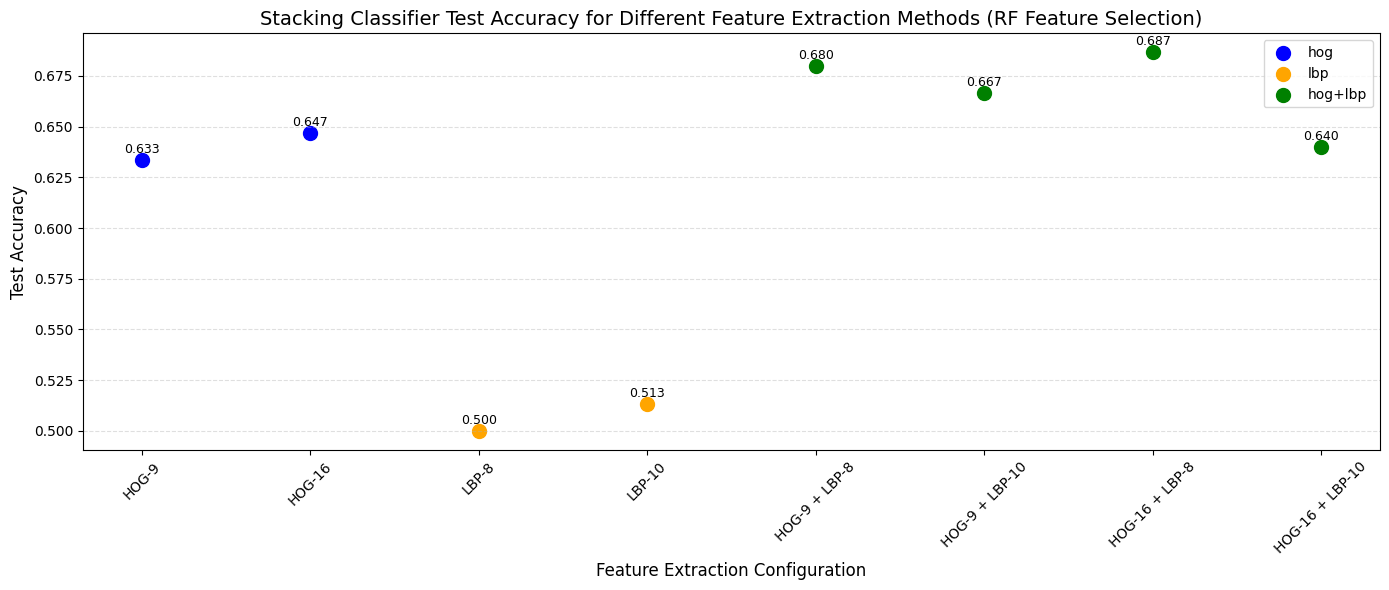

In [19]:
# -----------------------------
# Plot comparison (Stacking version)
# -----------------------------
df_results_stack_selec = pd.DataFrame(results_stack_selec)

colors = {"hog": "blue", "lbp": "orange", "hog+lbp": "green"}

plt.figure(figsize=(14, 6))

added_to_legend = set()  # prevent duplicate entries

for idx, row in df_results_stack_selec.iterrows():
    x = idx
    y = row["test_acc"]
    method = row["method"]

    # Scatter point
    plt.scatter(
        x, y,
        color=colors[method],
        s=100,
        label=method if method not in added_to_legend else None
    )
    added_to_legend.add(method)

    # Accuracy label above point
    plt.text(
        x, y + 0.002,
        f"{y:.3f}",
        ha="center", va="bottom",
        fontsize=9
    )

# Nicely formatted x-axis labels
def pretty_label(method, hp, lp):
    if method == "hog":
        return f"HOG-{hp['orientations']}"
    elif method == "lbp":
        return f"LBP-{lp['P']}"
    else:  # hog+lbp
        return f"HOG-{hp['orientations']} + LBP-{lp['P']}"

plt.xticks(
    range(len(df_results_stack_selec)),
    [
        pretty_label(r['method'], r['hog_params'], r['lbp_params'])
        for _, r in df_results_stack_selec.iterrows()
    ],
    rotation=45
)

plt.xlabel("Feature Extraction Configuration", fontsize=12)
plt.ylabel("Test Accuracy", fontsize=12)
plt.title("Stacking Classifier Test Accuracy for Different Feature Extraction Methods (RF Feature Selection)", fontsize=14)
plt.grid(True, axis="y", linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

---